In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple


class FactorModel(nn.Module):
    def __init__(self, N: int, K: List[int], d: int):
        super(FactorModel, self).__init__()
        self.N = N  # Number of questions
        self.K = K  # List of number of categorical answers for each question
        self.d = d  # Latent dimension
        self.W = nn.ModuleList([nn.Linear(d, K[i] - 1, bias=False) for i in range(N)])
        self.biases = nn.ParameterList(
            [nn.Parameter(torch.randn(K[i] - 1)) for i in range(N)]
        )

    def forward(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = [self.W[n](v) + self.biases[n] for n in range(self.N)]
        # Append zero logits for the last category to each question's logits
        logits = [
            torch.cat((logit, torch.zeros(logit.size(0), 1).to(logit.device)), dim=1)
            for logit in logits
        ]
        return logits

    def predict_proba(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = self.forward(v)  # List of logits for each question
        probabilities = [torch.softmax(logit, dim=-1) for logit in logits]
        return probabilities


def loss_function(
    model: FactorModel,
    v: torch.Tensor,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
) -> torch.Tensor:

    criterion = nn.NLLLoss(reduction="sum")
    logits = model.forward(v)

    total_loss = 0
    for n in range(model.N):
        log_probs = nn.functional.log_softmax(logits[n], dim=1)
        total_loss += criterion(log_probs, answers[:, n])

    # L2 Regularization
    l2_reg = sum(torch.norm(W.weight, 2) ** 2 for W in model.W)
    total_loss += lambda1 * l2_reg
    total_loss += lambda2 * torch.norm(v, 2) ** 2
    return total_loss


def train_model(
    model: FactorModel,
    answers: torch.Tensor,
    epochs: int = 1000,
    lr: float = 0.01,
    lambda1: float = 0.01,
    lambda2: float = 0.01,
) -> Tuple[FactorModel, torch.Tensor]:
    optimizer = optim.Adam(model.parameters(), lr=lr)
    v = torch.randn(len(answers), model.d, requires_grad=True)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function(model, v, answers, lambda1, lambda2)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return model, v

In [2]:
import json

N = 22  # number of questions
M = 100  # number of articles

with open("../CA/Alignment_eng_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)

# Initialize a list to store the extracted values
llm_zho = []

# Iterate through the JSON objects to extract `post_LLM_answer`
for item in data:
    if "QnA" in item:
        for qna in item["QnA"]:
            if "post_LLM_answer" in qna:
                llm_zho.append(qna["post_LLM_answer"])

# reshape the list to a MxN matrix
llm_zho = np.array(llm_zho).reshape(-1, 1)
llm_zho = np.array(llm_zho).reshape(M, N)

# replace A with  number 0, B with 1, C with 2, D with 3
llm_zho = np.where(llm_zho == "A", 0, llm_zho)
llm_zho = np.where(llm_zho == "B", 1, llm_zho)
llm_zho = np.where(llm_zho == "C", 2, llm_zho)
llm_zho = np.where(llm_zho == "D", 3, llm_zho)
llm_zho = np.where(llm_zho == "E", 4, llm_zho)
llm_zho = llm_zho.astype(int)
# convert llm_zho to numpy array
llm_zho = np.array(llm_zho)

In [3]:
llm_zho

array([[0, 1, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 2, 0],
       [0, 1, 0, ..., 1, 3, 0],
       ...,
       [0, 1, 0, ..., 0, 4, 4],
       [0, 1, 0, ..., 0, 4, 4],
       [0, 1, 0, ..., 1, 0, 1]])

In [4]:
import json

N = 22  # number of questions
M = 100  # number of articles

with open("../CA/Alignment_eng_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)

# Initialize a list to store the extracted values
llm_eng = []

# Iterate through the JSON objects to extract `post_LLM_answer`
for item in data:
    if "QnA" in item:
        for qna in item["QnA"]:
            if "post_LLM_answer" in qna:
                llm_eng.append(qna["post_LLM_answer"])

# reshape the list to a MxN matrix
llm_eng = np.array(llm_eng).reshape(-1, 1)
llm_eng = np.array(llm_eng).reshape(M, N)

# replace A with  number 0, B with 1, C with 2, D with 3
llm_eng = np.where(llm_eng == "A", 0, llm_eng)
llm_eng = np.where(llm_eng == "B", 1, llm_eng)
llm_eng = np.where(llm_eng == "C", 2, llm_eng)
llm_eng = np.where(llm_eng == "D", 3, llm_eng)
llm_eng = np.where(llm_eng == "E", 4, llm_eng)
llm_eng = llm_zho.astype(int)
# convert llm_zho to numpy array
llm_eng = np.array(llm_eng)

In [5]:
N = 21  # Number of questions
d = 3  # Latent dimension
# list of number of categorical answers for each question
K = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5]

model = FactorModel(N, K, d)

# Prepare Data
M = 200  # Number of articles
# merge the two languages
data = np.concatenate((llm_eng, llm_zho), axis=0)

data = data[:M, :N]
# convert data to torch tensor long
answers = torch.tensor(data, dtype=torch.long)

In [6]:
data.min(), data.max(), data.mean(axis=0)

(0,
 4,
 array([0.04, 0.89, 0.05, 0.79, 0.99, 0.78, 0.67, 0.51, 0.83, 0.99, 0.98,
        0.87, 0.92, 0.16, 0.31, 0.7 , 0.9 , 0.76, 0.65, 0.77, 1.2 ]))

In [7]:
data[-1]

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

In [8]:
answers

tensor([[0, 1, 0,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 0, 2],
        [0, 1, 0,  ..., 0, 1, 3],
        ...,
        [0, 1, 0,  ..., 1, 0, 4],
        [0, 1, 0,  ..., 1, 0, 4],
        [0, 1, 0,  ..., 0, 1, 0]])

In [9]:
epo = 1000 + 500 * d
trained_model, v = train_model(
    model, answers, epochs=epo, lr=0.01, lambda1=0.01, lambda2=0.01
)

/Users/minlingzhou/miniconda3/envs/my-env/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 0, Loss: 3755.386474609375
Epoch 100, Loss: 2541.26025390625
Epoch 200, Loss: 2169.021728515625
Epoch 300, Loss: 2018.5540771484375
Epoch 400, Loss: 1952.29052734375
Epoch 500, Loss: 1919.9814453125
Epoch 600, Loss: 1902.5360107421875
Epoch 700, Loss: 1892.2481689453125
Epoch 800, Loss: 1885.7447509765625
Epoch 900, Loss: 1881.4124755859375
Epoch 1000, Loss: 1878.4102783203125
Epoch 1100, Loss: 1876.266357421875
Epoch 1200, Loss: 1874.6978759765625
Epoch 1300, Loss: 1873.5279541015625
Epoch 1400, Loss: 1872.64111328125
Epoch 1500, Loss: 1871.959228515625
Epoch 1600, Loss: 1871.4285888671875
Epoch 1700, Loss: 1871.010986328125
Epoch 1800, Loss: 1870.6790771484375
Epoch 1900, Loss: 1870.4130859375
Epoch 2000, Loss: 1870.197998046875
Epoch 2100, Loss: 1870.0228271484375
Epoch 2200, Loss: 1869.87939453125
Epoch 2300, Loss: 1869.7611083984375
Epoch 2400, Loss: 1869.663330078125


In [10]:
print(trained_model.W[0].weight)

Parameter containing:
tensor([[-0.2539, -0.3521,  0.0568]], requires_grad=True)


In [11]:
v[0]

tensor([-0.4756, -0.6264,  1.1673], grad_fn=<SelectBackward0>)

In [12]:
trained_model.predict_proba(v[0].unsqueeze(0)), answers[0]

([tensor([[0.9739, 0.0261]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.1166, 0.8834]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.9229, 0.0771]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.2805, 0.7195]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0030, 0.9970]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.2150, 0.7850]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.3393, 0.6607]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.5463, 0.4537]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.1325, 0.8675]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0048, 0.9952]], grad_fn=<SoftmaxBackward0>),
  tensor([[7.6859e-04, 9.9923e-01]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0805, 0.9195]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0672, 0.9328]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.8619, 0.1381]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.7003, 0.2997]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.3428, 0.6572]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.1128, 0.8872]], grad_fn=<SoftmaxBackward0>),
  tens

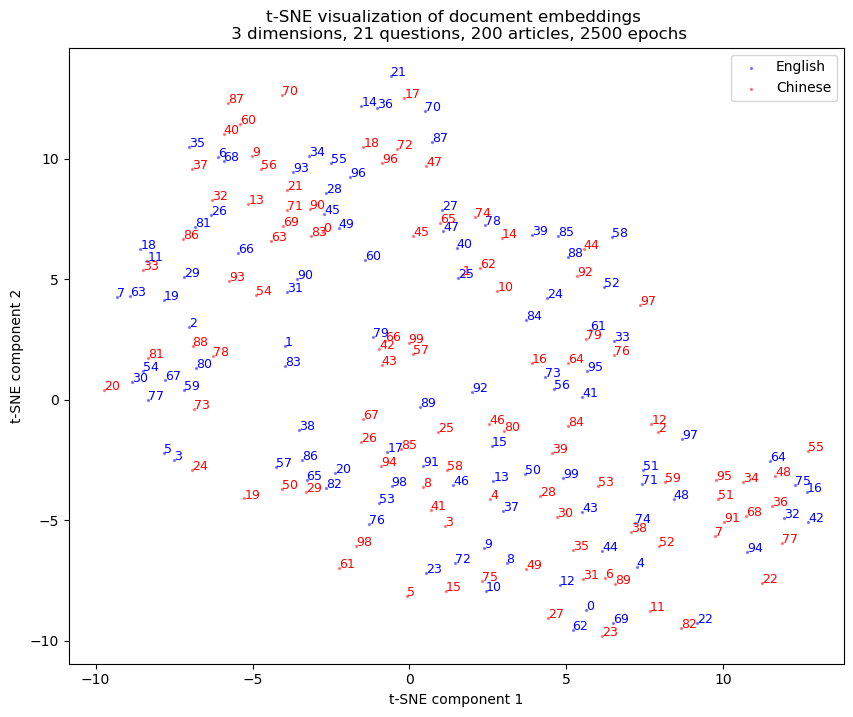

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# Extract the latent vectors v
latent_vectors = v.detach().numpy()

# Normalize the latent vectors
# scaler = StandardScaler()
# latent_vectors_normalized = scaler.fit_transform(latent_vectors)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
# v_2d = tsne.fit_transform(latent_vectors)
v_2d = tsne.fit_transform(latent_vectors)

# Plot the 2D embeddings with the inedx of each point
plt.figure(figsize=(10, 8))
# split the two languages
v_2d_eng = v_2d[:100]
v_2d_zho = v_2d[100:]
for index, (x, y) in enumerate(v_2d_eng):
    plt.scatter(
        x, y, alpha=0.4, color="blue", s=2, label="English" if index == 0 else ""
    )
    plt.text(x, y, str(index), fontsize=9, color="blue")

for index, (x, y) in enumerate(v_2d_zho):
    plt.scatter(
        x, y, alpha=0.4, color="red", s=2, label="Chinese" if index == 0 else ""
    )
    plt.text(x, y, str(index), fontsize=9, color="red")
plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)

plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.legend()
plt.show()

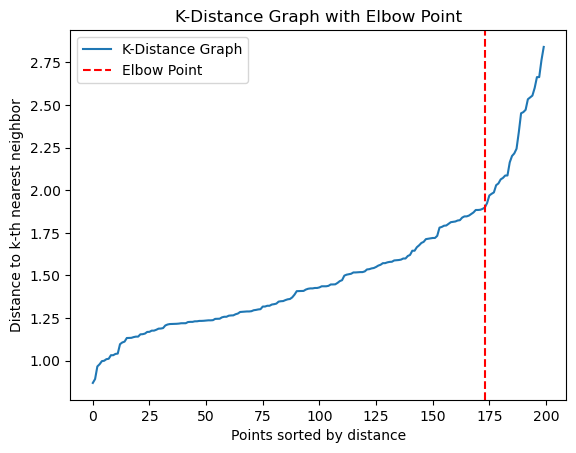

Elbow point (knee) is at index: 173, distance: 1.8987053549309323


In [14]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Compute k-nearest neighbors (k is set to min_samples)
min_samples = 5
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(v_2d)
distances, indices = nbrs.kneighbors(v_2d)

# Sort distances to the k-th nearest neighbor
distances = np.sort(distances[:, min_samples - 1])

x = np.arange(len(distances))
kneedle = KneeLocator(x, distances, curve="convex", direction="increasing")

# Plot the results
plt.plot(x, distances, label="K-Distance Graph")
plt.axvline(x=kneedle.knee, color="r", linestyle="--", label="Elbow Point")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to k-th nearest neighbor")
plt.title("K-Distance Graph with Elbow Point")
plt.legend()
plt.show()

# Print the knee point
print(
    f"Elbow point (knee) is at index: {kneedle.knee}, distance: {distances[kneedle.knee]}"
)

In [15]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=distances[kneedle.knee], min_samples=min_samples)
labels = dbscan.fit_predict(v_2d)

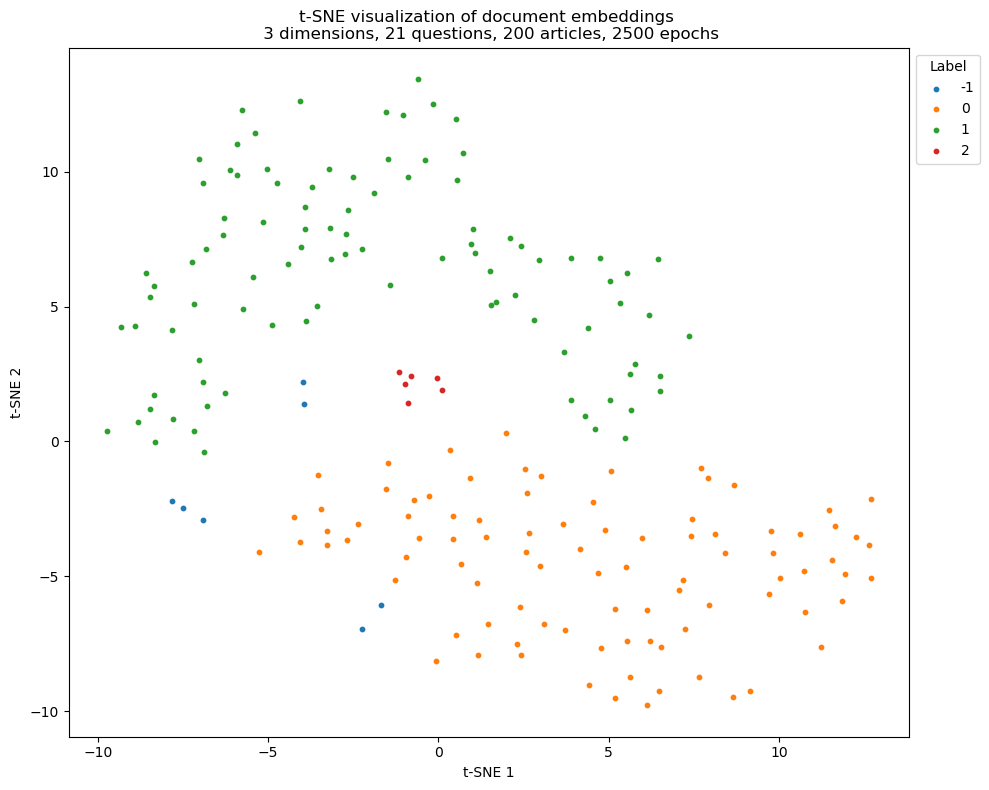

In [16]:
plt.figure(figsize=(10, 8))
for y in np.unique(labels):
    plt.scatter(
        v_2d[labels == y, 0], v_2d[labels == y, 1], label=f"{y}", s=10, marker="o"
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)
plt.legend(title="Label", loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()
plt.show()

In [17]:
# get the index of cluster -1
cluster_1 = np.where(labels == labels.max())
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

China says US plays 'dishonorable role' supporting PH in SCS
香会谈台海被主持人打断，我防长不受干扰继续发言，称必须先讲完_董军_中方_问题
小馬可仕香會強硬捍衛菲南海主權 陸外交部提6主張嗆「罔顧歷史事實」
外交部回应菲总统涉南海问题演讲：菲方有关表态罔顾历史和事实
﻿中方詰問菲律賓
無主權爭端北京斷金援 美承諾菲高科技投資


In [18]:
# get the index of cluster -1
cluster_1 = np.where(labels == labels.min())
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

Turkey's Top Diplomat Visits China, Planning Stops in Uyghur Genocide Region
Resetting the clock: Hun Sen urges US to restart dialogue and military cooperation - Khmer Times
Philippines denies its troops pointed guns at Chinese coast guard personnel
China says US plays 'dishonourable role' supporting Philippines in S.China Sea

10:37
                  外交部发言人就菲律宾总统马科斯在香格里拉对话会发表涉南海问题演讲答记者问
菲律宾又发涉南海错误言论 中方：请菲方先回答四个问题


In [19]:
# get the index of cluster -1
cluster_1 = np.where(labels == 0)
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

World News | Philippines Says China Coast Guard Seized Food Dropped by Plane for Filipino Forces in Disputed Sea | LatestLY
US Marines Deploy MQ-9 Reaper Drones to the Philippines - News From Antiwar.com
Philippines: Troops did not point weapons at Chinese coast guard | Honolulu Star-Advertiser
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines says China coast guard seized food dropped by plane for...
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
US Defense Secretary Lloyd Austin Confirms Restoration of US-Cambodia Ties, Joint Military Drills | CamboJA News
Philippines says troops held weapons but did not point at Chinese coast guard
Tensions Rise in South China Sea: A Stando

In [20]:
# get the index of cluster -1
cluster_1 = np.where(labels == 1)
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

Phl, U.S., Japan coast guards vow to keep SCS safe, free
Speaker says China's behavior won't improve ties
Commitment to peace - Manila Standard
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
China blames PH again on raising tensions in the West Philippine Sea
PBBM 'calm, not combative' in Shangri-La dialogue -- Jinggoy
Qualcomm Deepens Taiwan Ties with Kaohsiung Innovation Center for NASDAQ:QCOM by signalmastermind
UK professor's latest book backs China's claims over South China Sea islands
China says Philippines' actions towards Chinese coast guard illegal
Philippines says troops held weapons but did not point at Chinese
PH Navy slams Chinese military activities in Sabina Shoal
Philippines says troops held weapons but did not point at Chinese coast guard
Philippines says troops held weapons but did not point at Chinese coast guard
Philippine Troops Defend Against Chinese Coast Guard Provocation | Law-Order
'We have the right': Phili